In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import json

from IPython.display import clear_output

from lib.CAModel import CAModel
from lib.utils_vis import SamplePoolv2, to_alpha, to_rgb, get_living_mask, make_seed, make_circle_masks, make_targets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def load_emoji(index, path="data/emoji.png"):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*40:(index+1)*40].astype(np.float32))
    emoji /= 255.0
    return emoji

def load_new_im(path="data/kirby.png"):
    im = imageio.imread(path)
    im = np.array(im.astype(np.float32))
    im /= 255.0
    return im

def visualize_batch(x0, x, labels):
    vis0 = to_rgb(x0)
    vis1 = to_rgb(x)
    vis2 = to_rgb(labels)

    print('batch (before/after):')
    plt.figure(figsize=[15,4])
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1)
        plt.imshow(vis0[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1+x0.shape[0])
        plt.imshow(vis1[i])
        plt.axis('off')
    for i in range(x0.shape[0]):
        plt.subplot(3,x0.shape[0],i+1+2 * x0.shape[0])
        plt.imshow(vis2[i])
        plt.axis('off')


    plt.show()

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

In [31]:
device = torch.device("cuda:0")
model_path = "models/test2.pth"

CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 60

lr = 2e-3
lr_gamma = 0.9999
betas = (0.5, 0.5)
n_epoch = 80000

BATCH_SIZE = 16
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = 1 #@param "🦎"

EXPERIMENT_TYPE = "Regenerating"
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [43]:
with open("arc/training/007bbfb7.json") as file:
    data = json.loads(file.read())
train = data['train']
test = data['test']

test


<Figure size 576x576 with 0 Axes>

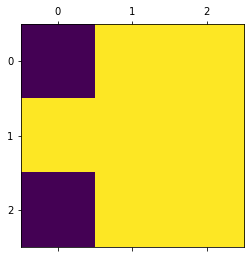

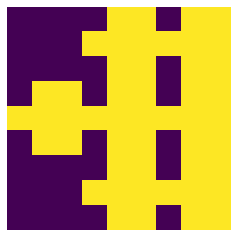

<Figure size 576x576 with 0 Axes>

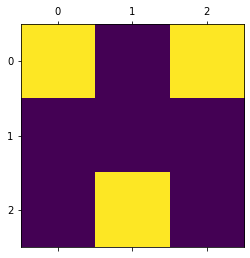

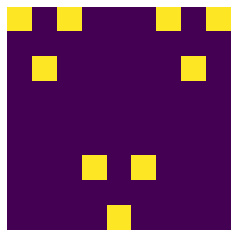

<Figure size 576x576 with 0 Axes>

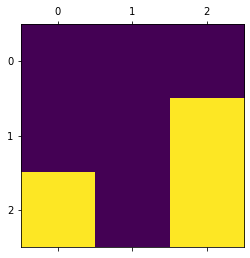

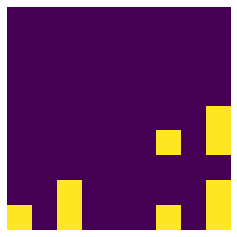

<Figure size 576x576 with 0 Axes>

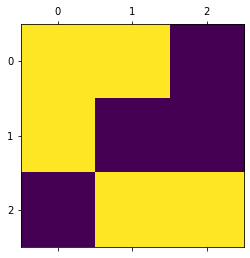

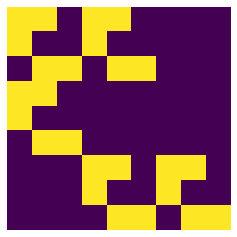

<Figure size 576x576 with 0 Axes>

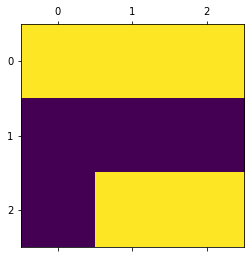

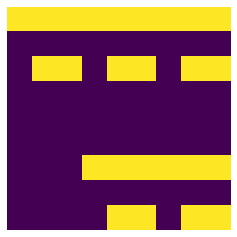

<Figure size 576x576 with 0 Axes>

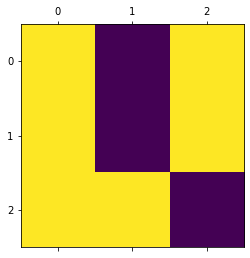

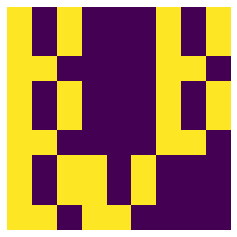

In [42]:
colors = {0: 0, 1:0x0074d9, 2: 0xFF4136, 3: 0x2ECC40, 4: 0xFFDC00, 5: 0xAAAAAA, 6: 0xF012BE, 7: 0xFF851B, 8: 0x7FDBFF, 9: 0x870C25}
#cmap = matplotlib.colors.ListedColormap(list(colors.values()))
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

for sample in train:
    plt.figure(figsize=(8,8))

    plt.matshow(sample['input'])
    plt.matshow(sample['output'])
    plt.axis('off')

plt.figure(figsize=(8,8))

print("test")
plt.matshow(test[0]['input'])
plt.matshow(test[0]['output'])
plt.axis('off')


plt.show()

In [ ]:
input = [sample['input'] in train]
output = [sample['output'] in train]

In [6]:
pool = SamplePoolv2(POOL_SIZE, CHANNEL_N, targets=[0, 1], seeds=seeds, device=device)
batch_x, batch_y = pool.sample(BATCH_SIZE)
print(batch_x.shape)
print(batch_y.shape)
w,h = batch_x.shape[1:3]
seeds = torch.from_numpy(np.array(seeds, dtype=np.float32))
print(seeds.shape)

torch.Size([16, 92, 92, 16])
(16,)
torch.Size([2, 92, 92, 16])


In [7]:
ca = CAModel(CHANNEL_N, CELL_FIRE_RATE, device).to(device)
ca.load_state_dict(torch.load("models/jmu_dog_v1.pth"))

optimizer = optim.Adam(ca.parameters(), lr=lr, betas=betas)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_gamma)

1900 loss = 0.011336402036249638
batch (before/after):


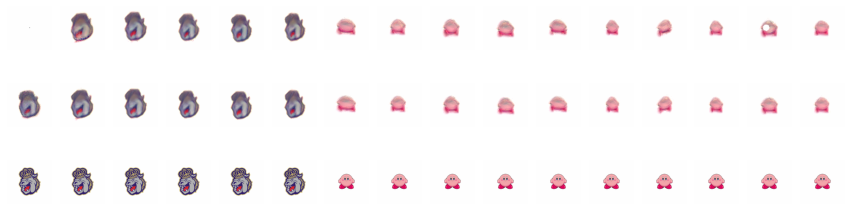

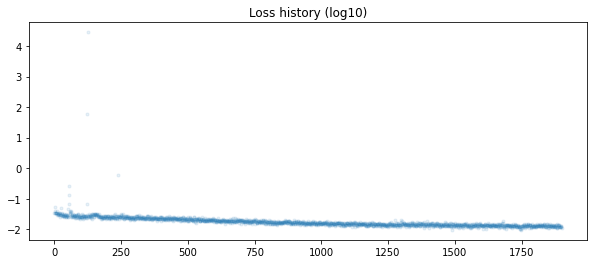

In [ ]:
loss_log = []

def train(x, target, steps, optimizer, scheduler):
    x = ca(x, steps=steps)
    loss = F.mse_loss(x[:, :, :, :4], target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    return x, loss

def loss_f(x, target):
    return torch.mean(torch.pow(x[..., :4]-target, 2), [-2,-3,-1])

for i in range(n_epoch+1):
    batch_x, batch_y = pool.sample(BATCH_SIZE)
        
    x0 = batch_x.detach().cpu().numpy()
    y0 = padded_targets[batch_y]
    loss_rank = loss_f(batch_x, y0).detach().cpu().numpy().argsort()[::-1]
    
    x0[loss_rank[0]] = seeds[batch_y[loss_rank[0]]]
    if DAMAGE_N:
        damage = 1.0-make_circle_masks(DAMAGE_N, h, w)[..., None]
        x0[loss_rank[loss_rank.shape[0] - DAMAGE_N:].copy()] *= damage
        
    x0 = torch.from_numpy(x0.astype(np.float32)).to(device)

    x, loss = train(x0, y0, np.random.randint(64,96), optimizer, scheduler)
    
    x = x.detach()
    pool.commit(x)
    
    step_i = len(loss_log)
    loss_log.append(loss.item())

    if step_i%100 == 0:
        clear_output()
        print(step_i, "loss =", loss.item())
        visualize_batch(x0.detach().cpu().numpy()[loss_rank], x.cpu().numpy()[loss_rank], y0.detach().cpu().numpy()[loss_rank])
        plot_loss(loss_log)
        torch.save(ca.state_dict(), model_path)


tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         ...,

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, n

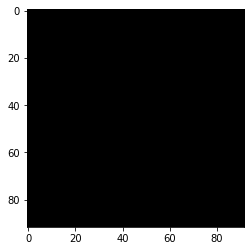

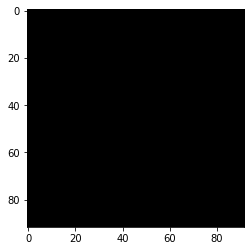

In [19]:
dog = ca(seeds[np.newaxis, 1].to(device), steps=1)
kirby = ca(seeds[np.newaxis, 0].to(device), steps=1)

plt.figure(figsize=(4,4))
plt.imshow(to_rgb(dog.detach().cpu().numpy()[0]))
plt.show()
plt.figure(figsize=(4,4))
plt.imshow(to_rgb(kirby.detach().cpu().numpy()[0]))
plt.show()